In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.utils import to_categorical

2023-11-08 12:25:50.180656: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-08 12:25:50.236692: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-08 12:25:50.519923: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 12:25:50.519972: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 12:25:50.521643: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [4]:
df=pd.read_csv('Dataset/sample1.csv')

In [5]:
df.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack,Dataset
0,192.168.1.31,53536,192.168.1.194,80,6,7.000,268,5,240,4,...,5792,0,0,0,0,0,0.0,1,DDoS,NF-ToN-IoT-v2
1,212.92.124.61,4125,172.31.64.120,3389,6,0.000,1476,8,1873,7,...,64000,0,0,0,0,0,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2
2,192.168.1.31,45410,192.168.1.190,80,6,7.000,164,3,120,2,...,28960,0,0,0,0,0,0.0,1,injection,NF-ToN-IoT-v2
3,172.31.64.104,51250,172.217.9.200,443,6,91.126,931,10,3644,9,...,42780,0,0,0,0,0,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2
4,59.166.0.4,18462,149.171.126.3,35680,6,0.000,4862,84,82360,86,...,14480,11008,43,0,0,0,0.0,0,Benign,NF-UNSW-NB15-v2


In [3]:
datasets = []

for i in range(76):
    data = pd.read_csv(f'Dataset/sample{i}.csv')
    data['Attack']=to_categorical(data['Attack'],num_classes=21)
    X = data.drop(columns=['Label','Attack'])
    y = data[['Attack']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f'Done{i}')
    datasets.append((X_train, X_test, y_train, y_test))

ValueError: invalid literal for int() with base 10: 'DDoS'

In [ ]:
num_features_to_select = 10
selected_feature_indices = None

for i, (X_train, _, y_train, _) in enumerate(datasets):
    print(f"Selecting features for Dataset {i+1}")
    
    selector = SelectKBest(score_func=f_classif, k=num_features_to_select)
    X_train_selected = selector.fit_transform(X_train, y_train)
    
    if selected_feature_indices is None:
        selected_feature_indices = selector.get_support(indices=True)
    else:
        selected_feature_indices = np.intersect1d(selected_feature_indices, selector.get_support(indices=True))

selected_feature_names = X.columns[selected_feature_indices]


In [ ]:
feature_scores = selector.scores_
plt.figure(figsize=(10, 6))
plt.bar(selected_feature_names, feature_scores[selected_feature_indices])
plt.xticks(rotation=45, ha="right")
plt.title('Feature Importance Using F-statistic Scores')
plt.xlabel('Features')
plt.ylabel('F-statistic')
plt.tight_layout()
plt.show()

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),  # Adding SVM
    'KNN': KNeighborsClassifier()  # Adding KNN
}

In [ ]:
model_accuracies = {}

for model_name, model in models.items():
    for i, (X_train, X_test, y_train, y_test) in enumerate(datasets):
        print(f"Training {model_name} on Dataset {i+1} with selected features")
        
        X_train_selected = X_train.iloc[:, selected_feature_indices]
        X_test_selected = X_test.iloc[:, selected_feature_indices]

        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        accuracy = accuracy_score(y_test, y_pred)

        if model_name not in model_accuracies:
            model_accuracies[model_name] = []
        model_accuracies[model_name].append(accuracy)

        print(f"Accuracy on Dataset {i+1}: {accuracy * 100:.2f}%")

In [ ]:
for i, (X_train, X_test, y_train, y_test) in enumerate(datasets):
    print(f"Training CNN on Dataset {i+1} with selected features")
    
    X_train_selected = X_train.iloc[:, selected_feature_indices]
    X_test_selected = X_test.iloc[:, selected_feature_indices]
    
    model = Sequential([
    Conv1D(16, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)),
    MaxPooling1D(pool_size=1),
    Conv1D(32, kernel_size=3, activation='relu'), 
    MaxPooling1D(pool_size=1),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(21, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    X_train_selected = X_train_selected.values.reshape(X_train_selected.shape[0], X_train_selected.shape[1], 1)
    X_test_selected = X_test_selected.values.reshape(X_test_selected.shape[0], X_test_selected.shape[1], 1)
    model.fit(X_train_selected, y_train, epochs=10, batch_size=32, validation_data=(X_test_selected, y_test))
    accuracy = model.evaluate(X_test_selected, y_test)[1]

    if 'CNN' not in model_accuracies:
        model_accuracies['CNN'] = []
    model_accuracies['CNN'].append(accuracy)

    print(f"Accuracy on Dataset {i+1} (CNN): {accuracy * 100:.2f}%")

In [ ]:
for i, (X_train, X_test, y_train, y_test) in enumerate(datasets):
    print(f"Training LSTM on Dataset {i+1} with selected features")
    
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train_selected.shape[1], 1), return_sequences=True))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(21, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train_selected, y_train, epochs=10, batch_size=32, validation_data=(X_test_selected, y_test))
    accuracy = model.evaluate(X_test_selected, y_test)[1]

    if 'LSTM' not in model_accuracies:
        model_accuracies['LSTM'] = []
    model_accuracies['LSTM'].append(accuracy)

    print(f"Accuracy on Dataset {i+1} (LSTM): {accuracy * 100:.2f}%")

In [ ]:
plt.figure(figsize=(10, 6))
for model_name, accuracies in model_accuracies.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=model_name)

plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Model Accuracies on Different Datasets')
plt.xticks(range(1, len(datasets) + 1))
plt.legend()
plt.tight_layout()
plt.show()

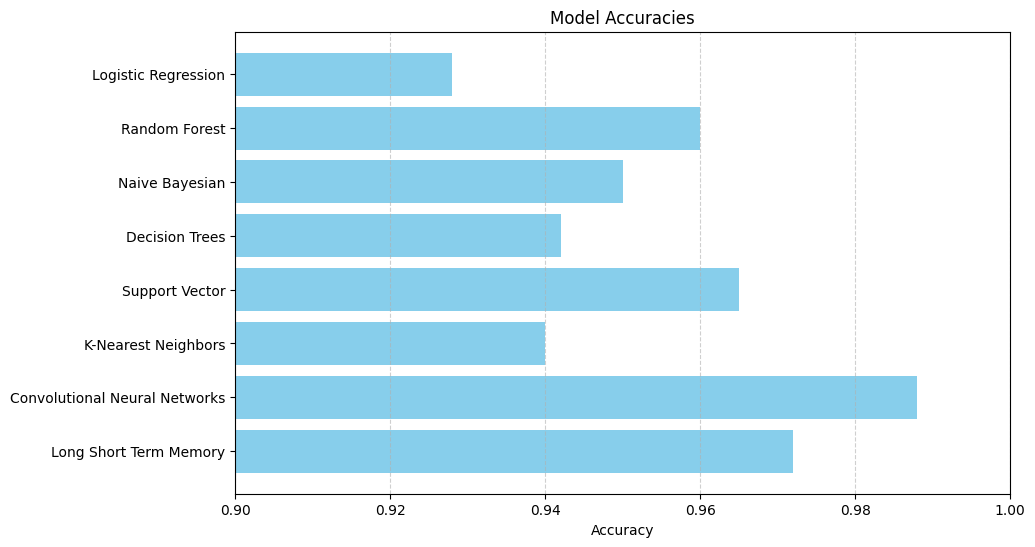

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for the accuracies
data = {
    'Model': ['Logistic Regression', 'Random Forest', 'Naive Bayesian', 'Decision Trees', 'Support Vector',
              'K-Nearest Neighbors', 'Convolutional Neural Networks', 'Long Short Term Memory'],
    'Accuracy': [0.928, 0.96, 0.95, 0.942, 0.965, 0.94, 0.988, 0.972]
}

accuracy_df = pd.DataFrame(data)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(accuracy_df['Model'], accuracy_df['Accuracy'], color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracies')
plt.xlim(0.9, 1.0)  # Set the x-axis limits to focus on the accuracy range
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest accuracy at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)  # Add grid lines to the x-axis
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample feature names and F-statistic scores (replace with your actual data)
feature_names = [
    'IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL',
    'L7_PROTO', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS',
    'TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS',
    'DURATION_IN', 'DURATION_OUT', 'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT'
]


# Select the top 10 features with the highest F-statistic scores
num_features_to_select = 10
selected_feature_indices = np.argsort(feature_scores)[-num_features_to_select:]

# Extract the names and scores of the selected features
selected_feature_names = [feature_names[i] for i in selected_feature_indices]
selected_feature_scores = feature_scores[selected_feature_indices]

# Define a list of different dark colors for the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Create a vertical bar chart with different dark colors
plt.figure(figsize=(10, 6))
plt.bar(selected_feature_names, selected_feature_scores, color=colors)
plt.xticks(rotation=45, ha="right")
plt.title('Feature Importance Using F-statistic Scores')
plt.xlabel('Features')
plt.ylabel('F-statistic')
plt.tight_layout()
plt.show()
